<a href="https://colab.research.google.com/github/Neermita18/SystemsBiology/blob/main/SolubiityWithGCNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
pip install deepchem

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 35.2 MB/s eta 0:00:00


In [4]:
pip install torch torchvision torch-geometric rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.2 MB/s eta 0:00:00


In [5]:
from torch_geometric.data import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import GCNConv, global_mean_pool
from rdkit import Chem
from rdkit.Chem import AllChem
import torch
import torch.nn as nn
import torch.optim as optim
from rdkit.Chem import AllChem, Draw
import deepchem as dc
import pandas as pd
import numpy as np
dataset = MoleculeNet(root='data/Freesolv', name='FreeSolv')

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Processing...
Done!


### Analysing the Dataset

In [6]:
dataset[0]

Data(x=[13, 9], edge_index=[2, 26], edge_attr=[26, 3], smiles='CN(C)C(=O)c1ccc(cc1)OC', y=[1, 1])

In [7]:
dataset[0].x

tensor([[6, 0, 4, 5, 3, 0, 4, 0, 0],
        [7, 0, 3, 5, 0, 0, 3, 0, 0],
        [6, 0, 4, 5, 3, 0, 4, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 0, 0],
        [8, 0, 1, 5, 0, 0, 3, 0, 0],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 0, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [6, 0, 3, 5, 1, 0, 3, 1, 1],
        [8, 0, 2, 5, 0, 0, 3, 0, 0],
        [6, 0, 4, 5, 3, 0, 4, 0, 0]])

In [8]:
dataset[0].edge_index

tensor([[ 0,  1,  1,  1,  2,  3,  3,  3,  4,  5,  5,  5,  6,  6,  7,  7,  8,  8,
          8,  9,  9, 10, 10, 11, 11, 12],
        [ 1,  0,  2,  3,  1,  1,  4,  5,  3,  3,  6, 10,  5,  7,  6,  8,  7,  9,
         11,  8, 10,  5,  9,  8, 12, 11]])

In [9]:
dataset[0].edge_attr

tensor([[ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  0],
        [ 1,  0,  1],
        [ 1,  0,  0],
        [ 1,  0,  1],
        [ 2,  0,  1],
        [ 1,  0,  1],
        [ 2,  0,  1],
        [ 1,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [ 1,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [12,  0,  1],
        [ 1,  0,  1],
        [ 1,  0,  0],
        [ 1,  0,  0]])

In [10]:
x=dataset[0].smiles

In [11]:
mols= Chem.MolFromSmiles(x)

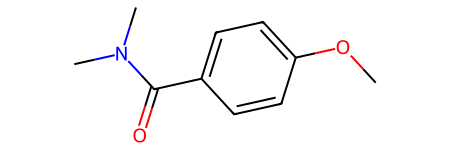

In [12]:
mols

In [13]:
feat=dc.feat.RDKitDescriptors()

In [14]:
data = pd.read_csv("/content/SAMPL_df_revised.csv")

FileNotFoundError: [Errno 2] No such file or directory: '/content/SAMPL_df_revised.csv'

In [ ]:
data

In [ ]:
dataset[0].y

So, the target values are the experimental hydration energies

### Model Creation

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import global_add_pool

In [41]:
class MPNN(nn.Module):
  def __init__(self, node_dim, edge_dim=None, hidden_dim=64):
    super(MPNN, self).__init__()
    self.node=node_dim
    self.edge=edge_dim
    self.hidden=hidden_dim
    self.lin0= nn.Linear(in_features=node_dim, out_features=hidden_dim)
    self.conv1= GCNConv(in_channels=hidden_dim, out_channels=hidden_dim)
    self.conv2= GCNConv(in_channels=hidden_dim, out_channels=hidden_dim)

    # Feature update layer
    self.feature_update= nn.Linear(in_features=2*hidden_dim, out_features=hidden_dim)

  def forward(self, edge_index, node_attr):
    x=self.lin0(node_attr)
    x1=F.relu(self.conv1(x, edge_index))
    x2=F.relu(self.conv2(x1, edge_index))
    x=self.feature_update(torch.cat([x, x2], dim=1))
    return x



In [42]:
class SoluGCN(nn.Module):
  def __init__(self, node_dim, edge_dim=None, hidden_dim=64):
    super(SoluGCN, self).__init__()
    self.node=node_dim
    self.edge=edge_dim
    self.hidden=hidden_dim
    self.mpnn = MPNN(node_dim, edge_dim, hidden_dim)
    self.lin1=nn.Linear(in_features=hidden_dim, out_features=128)
    self.lin2=nn.Linear(in_features=128, out_features=64)
    self.lin3=nn.Linear(in_features=64, out_features=1)
    self.pool = global_add_pool

  def forward(self, dataset):
    x, edge_index, batch = data.x, data.edge_index, data.batch
    x=self.mpnn(x, edge_index)
    x=self.pool(x, batch)
    x=F.relu(self.lin1(x))
    x=F.relu(self.lin2(x))
    x=self.lin3(x)
    return x



In [21]:
dataset.data

/usr/local/lib/python3.10/dist-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)


Data(x=[5600, 9], edge_index=[2, 10770], edge_attr=[10770, 3], y=[642, 1], smiles=[642])

In [22]:
train_dataset= dataset[:int(0.8 * len(dataset))]
val_dataset= dataset[int(0.8 * len(dataset)):int(0.9 * len(dataset))]
test_dataset= dataset[int(0.9 * len(dataset)):]

In [23]:
train_dataset

FreeSolv(513)

In [28]:
test_dataset[0]

Data(x=[9, 9], edge_index=[2, 18], edge_attr=[18, 3], smiles='Cc1ccc(cc1C)O', y=[1, 1])

In [27]:
train_dataset[0]

Data(x=[13, 9], edge_index=[2, 26], edge_attr=[26, 3], smiles='CN(C)C(=O)c1ccc(cc1)OC', y=[1, 1])

In [29]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [36]:
dataset.num_node_features

9

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
model = SoluGCN(node_dim=dataset.num_node_features, hidden_dim=64).to(device)

In [44]:
model

SoluGCN(
  (mpnn): MPNN(
    (lin0): Linear(in_features=9, out_features=64, bias=True)
    (conv1): GCNConv(64, 64)
    (conv2): GCNConv(64, 64)
    (feature_update): Linear(in_features=128, out_features=64, bias=True)
  )
  (lin1): Linear(in_features=64, out_features=128, bias=True)
  (lin2): Linear(in_features=128, out_features=64, bias=True)
  (lin3): Linear(in_features=64, out_features=1, bias=True)
)